![](https://upload.wikimedia.org/wikipedia/pt/8/80/Enem_logo.png)
# Projeto Tópicos Avançados em GDI - ENEM 2021
Neste projeto, desenvolvemos uma análise exploratória de dados utilizando a base de dados do [ENEM 2021](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem), passando por todos os passos de uma análise de dados como: **pre-processamento dos dados, processamentos dos dados, visualização, análise de métricas descritivias, detecção de outliers, inputação de dados e teste de hipótese**.

## Instalação de ferramentas
Nesta seção, instalamos todas as dependências necessárias para o funcionamento da nessa análise.


In [ ]:
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

pd.options.mode.chained_assignment = None

## Coleta e separação dos dados
Como pode-se imaginar, fizemos uso de uma base de dados disponibilizada pelo governo brasileiro relativo ao ENEM 2021. Esta possuí vários tipos de dados, mas para nossa análise usaremos apenas dados relativos as **notas dos participantes** e **dados dos participantes**.

Para tal, pelo grande tamanho de nosso dataset, aproximadamento 2 GB de dados, utilizamos a ténica de sampleamento para prosseguir com nossa análise.

### Sampleamento
Nosso sampleamento fez uso de uma técnica muito simples, para tal, separamos as primeiras 300 mil linhas do dataset original, assim resultando em um arquivo com 300 MB.

Fizemos isto consciêntes de que essa escolha poderia gerar ruídos ou tendências em nosso dataset. Assim, para evitar isto a melhor maneira de proceder com essa operação seria fazer um sampleamento randômnico ou utilizando técnicas mais avançadas de balancemaneto de amostras.

## Dicionário
Para o correto entendimento de nosso dados, disponibilizamos [neste link](https://docs.google.com/spreadsheets/d/1-y2XLTG_AWINH6F4FKPcjfNl1yeFIPujACHJwHKMR5Y/edit?usp=sharing) os sigficados dos campos que serão trabalhados neste análise.

Também disponibilizamos o sample do dataset que usamos [neste link](https://drive.google.com/drive/folders/1e7p0jmvarkBoupnZAErkrlykCUNucI73?usp=sharing).

In [ ]:
enem = pd.read_csv("SAMPLE_MICRODADOS_ENEM_2021.csv", sep=";" ,encoding = "ISO-8859-1")

participantes_columns = ['NU_INSCRICAO', 'TP_FAIXA_ETARIA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', ]
participantes = enem[participantes_columns]
participantes.columns = ['id', 'faixa_etaria', 'situacao_de_conclusao', 'ano_de_conclusao']

notas_columns = ['NU_INSCRICAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
notas = enem[notas_columns]
notas.columns = ['id', 'ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'matematica', 'redacao']
colunas_notas = ['ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'matematica', 'redacao']
notas.head()

,id,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
0,210053865474,NaN,574.6,472.6,NaN,760.0
1,210052384164,505.9,551.8,498.3,461.5,560.0
2,210052589243,NaN,NaN,NaN,NaN,NaN
3,210052128335,580.7,678.9,638.9,659.5,780.0
4,210051353021,497.7,532.4,457.6,582.6,780.0


## Análise exploratória dos dados

### Definição de tipos
Em nosso sample, possuímos as seguintes categorias de dados:
- **Categóricos nominal**: faixa_etária dos estudates, situação de conclusão. 
- **Dados numéricos**: notes de ciências naturais, ciências humanas, linguagem de código, matemática e redação e etc.

In [ ]:
notas.dtypes

id                     int64
ciencias_naturais    float64
ciencias_humanas     float64
linguagem_codigo     float64
matematica           float64
redacao              float64
dtype: object

In [ ]:
participantes.dtypes

id                       int64
faixa_etaria             int64
situacao_de_conclusao    int64
ano_de_conclusao         int64
dtype: object

### Adequando os tipos categóricos
Aqui iremos adequar as categorias de faixa etária e a situação de conclusão do ensino médio dos participantes. Adicionaremos descrições a estes dados categóricos para melhor leitura. 

In [ ]:
participantes['faixa_etaria'] = participantes['faixa_etaria'].astype('category')
participantes['situacao_de_conclusao'] = participantes['situacao_de_conclusao'].astype('category')
participantes.dtypes

id                          int64
faixa_etaria             category
situacao_de_conclusao    category
ano_de_conclusao            int64
dtype: object

In [ ]:
participantes['faixa_etaria'].cat.categories

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64')

In [ ]:
participantes['situacao_de_conclusao'].cat.categories

Int64Index([1, 2, 3, 4], dtype='int64')

In [ ]:
participantes['nome_situacao_de_conclusao'] = 'Ja conclui o Ensino Medio'
participantes.loc[participantes['situacao_de_conclusao'] == 2 , 'nome_situacao_de_conclusao'] = 'Estou cursando e concluirei o Ensino Medio em 2021'
participantes.loc[participantes['situacao_de_conclusao'] == 3 , 'nome_situacao_de_conclusao'] = 'Estou cursando e concluirei o Ensino Medio apos 2021'
participantes.loc[participantes['situacao_de_conclusao'] == 4 , 'nome_situacao_de_conclusao'] = 'Nao conclui e não estou cursando o Ensino Medio'
participantes['nome_situacao_de_conclusao'] = participantes['nome_situacao_de_conclusao'].astype('category')
participantes.head()

,id,faixa_etaria,situacao_de_conclusao,ano_de_conclusao,nome_situacao_de_conclusao
0,210053865474,5,1,3,Ja conclui o Ensino Medio
1,210052384164,12,1,11,Ja conclui o Ensino Medio
2,210052589243,13,1,15,Ja conclui o Ensino Medio
3,210052128335,3,2,0,Estou cursando e concluirei o Ensino Medio em ...
4,210051353021,2,2,0,Estou cursando e concluirei o Ensino Medio em ...


In [ ]:
participantes['nome_situacao_de_conclusao'].cat.categories

Index(['Estou cursando e concluirei o Ensino Medio apos 2021',
       'Estou cursando e concluirei o Ensino Medio em 2021',
       'Ja conclui o Ensino Medio',
       'Nao conclui e não estou cursando o Ensino Medio'],
      dtype='object')

In [ ]:
participantes['code_situacao_de_conclusao'] = participantes['nome_situacao_de_conclusao'].cat.codes
participantes.head()

,id,faixa_etaria,situacao_de_conclusao,ano_de_conclusao,nome_situacao_de_conclusao,code_situacao_de_conclusao
0,210053865474,5,1,3,Ja conclui o Ensino Medio,2
1,210052384164,12,1,11,Ja conclui o Ensino Medio,2
2,210052589243,13,1,15,Ja conclui o Ensino Medio,2
3,210052128335,3,2,0,Estou cursando e concluirei o Ensino Medio em ...,1
4,210051353021,2,2,0,Estou cursando e concluirei o Ensino Medio em ...,1


### Visualização geral dos nossos dados

#### Notas

In [ ]:
notas.describe()

,id,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
count,2.999990e+05,232565.000000,242841.000000,242841.000000,232565.000000,242841.000000
mean,2.100527e+11,488.381383,521.076241,502.510050,532.038919,646.189317
std,9.979763e+05,80.815677,94.369505,78.177863,110.280714,189.255659
min,2.100510e+11,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.100519e+11,428.000000,447.700000,448.300000,442.700000,540.000000
50%,2.100527e+11,476.400000,521.800000,504.500000,510.000000,640.000000
75%,2.100536e+11,540.100000,588.700000,557.300000,607.800000,800.000000
max,2.100545e+11,867.100000,846.900000,794.200000,953.100000,1000.000000


#### Participantes

In [ ]:
participantes.describe()

,id,ano_de_conclusao,code_situacao_de_conclusao
count,2.999990e+05,299999.000000,299999.000000
mean,2.100527e+11,1.549182,1.321278
std,9.979763e+05,3.224247,0.655937
min,2.100510e+11,0.000000,0.000000
25%,2.100519e+11,0.000000,1.000000
50%,2.100527e+11,0.000000,1.000000
75%,2.100536e+11,2.000000,2.000000
max,2.100545e+11,15.000000,3.000000


### Detecção de dados ausentes
Nesta seção, faremos um levantamento de quantas instâncias de dados possuem: ao menos 1 coluna nula, mais de 1 coluna nula, nenhuma coluna nula etc. Posteriormente também implementaremos técnicas para solver este tipo de problema, como inputação a partir da média, mediana, randômico até técnicas mais refinadas como KNN.

#### Levantamento de instâncias que possuem ao menos uma coluna nula

In [ ]:
print(participantes.isnull().sum())

id                            0
faixa_etaria                  0
situacao_de_conclusao         0
ano_de_conclusao              0
nome_situacao_de_conclusao    0
code_situacao_de_conclusao    0
dtype: int64


In [ ]:
print(notas.isnull().sum())

id                       0
ciencias_naturais    67434
ciencias_humanas     57158
linguagem_codigo     57158
matematica           67434
redacao              57158
dtype: int64


In [ ]:
notas_incompletas = notas[notas.isna().any(axis=1)]
qtd_notas_incompletas = len(notas_incompletas)
pct_notas_incompletas = (qtd_notas_incompletas/len(notas))*100
print(f'{pct_notas_incompletas:.1f}% de nossos dados de notas possui algum valor nulo.')

22.7% de nossos dados de notas possui algum valor nulo.


In [ ]:
# quantidade de instancias em notas
len(notas)

299999

#### Removendo instancias com pelo menos 1 campo nulo

In [ ]:
notas_removidas_1_dado_ausente = notas.dropna()
print(len(notas_removidas_1_dado_ausente))

231965


In [ ]:
print(notas_removidas_1_dado_ausente.isnull().sum())

id                   0
ciencias_naturais    0
ciencias_humanas     0
linguagem_codigo     0
matematica           0
redacao              0
dtype: int64


#### Removendo colunas quase vazias com ao menos 60% de dados ausentes

In [ ]:
notas_removidas_60porcentagem_dados_ausente = notas.dropna(thresh=0.6*len(notas), axis=1)
len(notas_removidas_60porcentagem_dados_ausente)

299999

### Inputamento de dados
Aqui implementamos técnicas para solver o problema de dados faltantes, como inputação a partir da média, mediana, randômico até técnicas mais refinadas como KNN.


Para seguir com estas técnicas, apenas para caso de estudo usaremos uma versão ainda maisr reduzida de nosso dataset, apenas as primeiras 10 mil instâncias.

In [ ]:
sample_notas = notas[:10000]
sample_notas = sample_notas.drop(['id'], axis=1)

#### Utilizando média e mediana
Usaremos as notas de **matemática** como exemplo para as seguintes aplicações. 

In [ ]:
print(sample_notas['matematica'].mean())
print(sample_notas['matematica'].median())

528.0250546623794
504.3


Aqui implementamos o inputamento utilizando a média e moda das notas de matemática. Também utilizamos inputamento utilizando números randômicos.

In [ ]:
notas_inputamento_media = sample_notas.copy()
notas_inputamento_mediana = sample_notas.copy()
notas_inputamento_random = sample_notas.copy()

notas_inputamento_media['matematica'].fillna(sample_notas['matematica'].mean(), inplace=True)

notas_inputamento_mediana['matematica'].fillna(sample_notas['matematica'].median(), inplace=True)

notas_inputamento_random['matematica'].fillna(random.uniform(sample_notas['matematica'].min(),sample_notas['matematica'].max()), inplace=True)

print(notas_inputamento_media.isnull().sum())

ciencias_naturais    2225
ciencias_humanas     1888
linguagem_codigo     1888
matematica              0
redacao              1888
dtype: int64


Para completar estes preenchimentos, visualizamos as correlações entre as notas nos samples de dataset que: 
- Possuem todas as instâncias incompletar (`notas`)
- Inputadas utilizando média (`notas_inputamento_media`),
- Inputadas utilizando mediana (`notas_inputamento_mediana`)
- E por fim as que foram inputadas utilizando numeros randômicos (`notas_inputamento_random`).

In [ ]:
sample_notas.corr(method='spearman')

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.000000,0.658360,0.649132,0.578017,0.487862
ciencias_humanas,0.658360,1.000000,0.771203,0.598386,0.550143
linguagem_codigo,0.649132,0.771203,1.000000,0.612864,0.556312
matematica,0.578017,0.598386,0.612864,1.000000,0.517486
redacao,0.487862,0.550143,0.556312,0.517486,1.000000


In [ ]:
notas_inputamento_media.corr(method='spearman')

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.000000,0.658360,0.649132,0.578017,0.487862
ciencias_humanas,0.658360,1.000000,0.771203,0.575157,0.550143
linguagem_codigo,0.649132,0.771203,1.000000,0.591321,0.556312
matematica,0.578017,0.575157,0.591321,1.000000,0.492817
redacao,0.487862,0.550143,0.556312,0.492817,1.000000


In [ ]:
notas_inputamento_mediana.corr(method='spearman')

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.000000,0.658360,0.649132,0.578017,0.487862
ciencias_humanas,0.658360,1.000000,0.771203,0.580305,0.550143
linguagem_codigo,0.649132,0.771203,1.000000,0.595671,0.556312
matematica,0.578017,0.580305,0.595671,1.000000,0.499857
redacao,0.487862,0.550143,0.556312,0.499857,1.000000


In [ ]:
notas_inputamento_random.corr(method='spearman')

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.000000,0.658360,0.649132,0.578017,0.487862
ciencias_humanas,0.658360,1.000000,0.771203,0.500817,0.550143
linguagem_codigo,0.649132,0.771203,1.000000,0.519996,0.556312
matematica,0.578017,0.500817,0.519996,1.000000,0.413467
redacao,0.487862,0.550143,0.556312,0.413467,1.000000


#### Utilizando KNN

In [ ]:
imputer = KNNImputer(n_neighbors=3)

In [ ]:
notas_imputacao_knn = imputer.fit_transform(sample_notas)
notas_imputacao_knn = pd.DataFrame(notas_imputacao_knn, columns=colunas_notas)

In [ ]:
print(notas_imputacao_knn.isnull().sum())

ciencias_naturais    0
ciencias_humanas     0
linguagem_codigo     0
matematica           0
redacao              0
dtype: int64


#### Conclusão
Podemos perceber com clareza que os inputamentos utilizando média e mediana foram bem sucedidos, mantendo as correlações próximas a intervalos aceitáveis. Já o inputamento utilizando números randômicos podemos perceber discrepâncias relevantes, o que ja era esperado pela ineficácia deste método.

Por fim, percebemos com destaque o inputamento utilizando KNN pela menor taxa de desvio padrão alcançada.

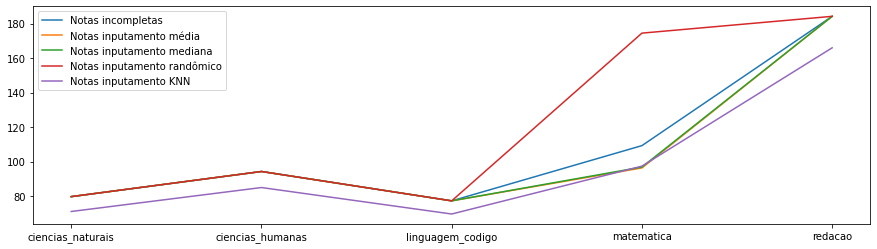

In [ ]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(sample_notas.std(), label = "Notas incompletas")
ax.plot(notas_inputamento_media.std(), label = "Notas inputamento média")
ax.plot(notas_inputamento_mediana.std(), label = "Notas inputamento mediana")
ax.plot(notas_inputamento_random.std(), label = "Notas inputamento randômico")
ax.plot(notas_imputacao_knn.std(), label = "Notas inputamento KNN")

plt.legend()
plt.show()

### Detecção de Outliers
Como pudemos visualizar dentro nossos boxplots, possuímos uma quantidade significante de pontos fora da curva, e estes tendem a gerar ruídos e tendenciar nossas análises. Para resolver tal problema, nesta seção aplicaremos técnicas como ZScore, ZScore Robusto e Tukey para remoção destas instâncias, e avaliaremos sua eficácia.

#### Correlação entre humanas e linguagens
Para aplicar tais técnicas, escolheremos uma amostra de nosso dataset, utilizaremos as notas de linguagens e de humanas.

Aqui podemos observar um conjunto de pontos fora da curva, presentes no ponto 0 do eixo X e Y, que deslocam o nosso gráfico.

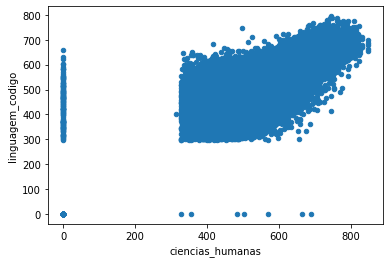

In [ ]:
notas_completas = notas.dropna()
humanas_linguagens = notas_completas[['id', 'linguagem_codigo', 'ciencias_humanas']]
humanas_linguagens.plot(kind='scatter', x='ciencias_humanas', y='linguagem_codigo')

A primeira limpeza que será feita, será a remoção destes dados que possuem 0 em uma ou em outra nota.

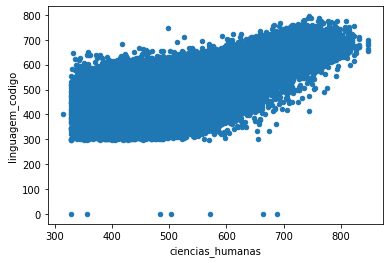

In [ ]:
humanas_linguagens_sem_outliers = humanas_linguagens[humanas_linguagens['linguagem_codigo'] > 0]
humanas_linguagens_sem_outliers = humanas_linguagens[humanas_linguagens['ciencias_humanas'] > 0]
humanas_linguagens_sem_outliers.plot(kind='scatter', x='ciencias_humanas', y='linguagem_codigo')

#### ZScore
Aqui aplicamos a ténica do ZScore para detectar os últimos outliers restantes e remove-los de nosso dataset

In [ ]:
humanas_linguagens_outliers_zscore = humanas_linguagens_sem_outliers[(stats.zscore(humanas_linguagens) > 3).all(axis=1)]
humanas_linguagens_sem_outliers = humanas_linguagens.drop(humanas_linguagens_outliers_zscore.index)
len(humanas_linguagens_outliers_zscore)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0

### Visualizações

#### Mínimo, Máximo, Média e outliers
Neste podemos observar métricas como min, média, max e outliers de cada nota presente em nosso dataset.

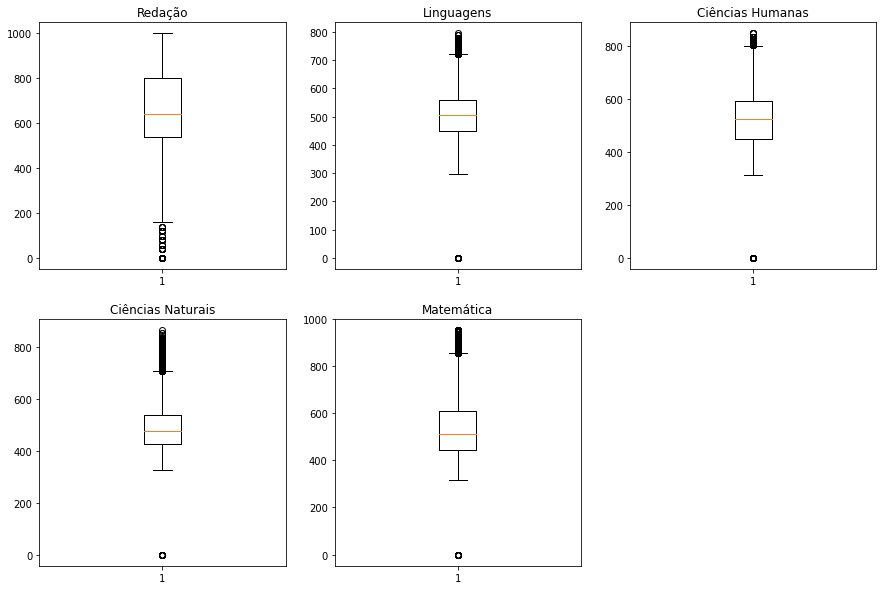

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15, 10))

redacao = notas_completas['redacao']
linguagem_codigo = notas_completas['linguagem_codigo']
ciencias_humanas = notas_completas['ciencias_humanas']
ciencias_naturais = notas_completas['ciencias_naturais']
matematica = notas_completas['matematica']

figure.delaxes(axis[1,2])

axis[0, 0].boxplot(redacao)
axis[0, 0].set_title("Redação")
  
axis[0, 1].boxplot(linguagem_codigo)
axis[0, 1].set_title("Linguagens")
  
axis[0, 2].boxplot(ciencias_humanas)
axis[0, 2].set_title("Ciências Humanas")
  
axis[1, 0].boxplot(ciencias_naturais)
axis[1, 0].set_title("Ciências Naturais")

axis[1, 1].boxplot(matematica)
axis[1, 1].set_title("Matemática")
  

plt.show()


Aqui, cruzamos os dados de participantes com os dados de notas de humanas e linguagens

In [ ]:
participantes_humanas_linguagem = participantes[participantes.id.isin(humanas_linguagens_sem_outliers['id'])]
participantes_humanas_linguagem.groupby('faixa_etaria').head()

,id,faixa_etaria,situacao_de_conclusao,ano_de_conclusao,nome_situacao_de_conclusao,code_situacao_de_conclusao
1,210052384164,12,1,11,Ja conclui o Ensino Medio,2
3,210052128335,3,2,0,Estou cursando e concluirei o Ensino Medio em ...,1
4,210051353021,2,2,0,Estou cursando e concluirei o Ensino Medio em ...,1
8,210053417016,8,2,0,Estou cursando e concluirei o Ensino Medio em ...,1
9,210051128744,4,2,0,Estou cursando e concluirei o Ensino Medio em ...,1
...,...,...,...,...,...,...
23028,210051848498,19,1,0,Ja conclui o Ensino Medio,2
27874,210052809724,20,1,0,Ja conclui o Ensino Medio,2
56882,210054121659,20,1,15,Ja conclui o Ensino Medio,2
96605,210051067629,20,1,9,Ja conclui o Ensino Medio,2


#### Faixa etária dos participantes

Existe um número significativo de pessoas entre 17 e 
21 anos que realizaram a prova que não zeraram ciencias humanas e nem linguagens.

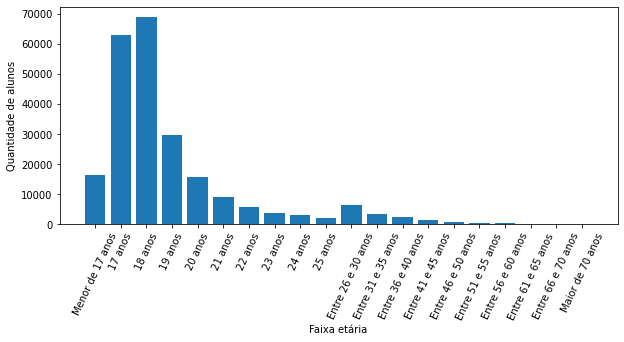

In [ ]:
xticks = ['Menor de 17 anos', '17 anos', '18 anos', '19 anos', '20 anos', '21 anos', '22 anos', '23 anos', '24 anos', '25 anos', 'Entre 26 e 30 anos', 'Entre 31 e 35 anos', 'Entre 36 e 40 anos', 'Entre 41 e 45 anos', 'Entre 46 e 50 anos', 'Entre 51 e 55 anos', 'Entre 56 e 60 anos', 'Entre 61 e 65 anos', 'Entre 66 e 70 anos', 'Maior de 70 anos']
participantes_humanas_linguagem_agrupado = participantes_humanas_linguagem.groupby('faixa_etaria')['id'].count()

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(xticks, participantes_humanas_linguagem_agrupado.values)

ax.set_xticklabels(xticks, rotation=65)
ax.set_xlabel('Faixa etária')
ax.set_ylabel('Quantidade de alunos')

plt.show()

Existe um número significativo de pessoas que vão concluir o ensino médio no ano que realizaram a prova que possuem 18 anos que não zeraram ciencias humanas e nem linguagens

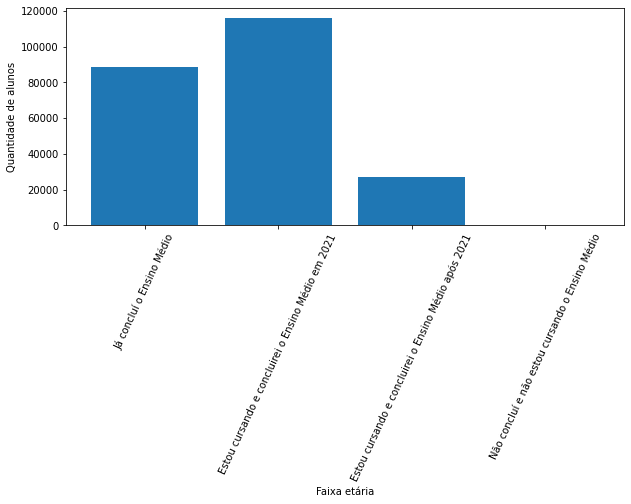

In [ ]:

xticks= ['Já concluí o Ensino Médio', 'Estou cursando e concluirei o Ensino Médio em 2021', 'Estou cursando e concluirei o Ensino Médio após 2021', 'Não concluí e não estou cursando o Ensino Médio']
participantes_humanas_linguagem_agrupado_sit_de_concl = participantes_humanas_linguagem.groupby('situacao_de_conclusao')['id'].count()

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(xticks, participantes_humanas_linguagem_agrupado_sit_de_concl.values)

ax.set_xticklabels(xticks, rotation=65)
ax.set_xlabel('Faixa etária')
ax.set_ylabel('Quantidade de alunos')

plt.show()

## Testes de hipótese


Aqui nós faremos o teste de hipóteses a respeito dos grupos de situações de participantes do enem e suas notas de matemática.

Iremos adotar como valor crítico 0.05 (5%).

Como a ideia é pegar os grupos de situação de conclusão do ensino médio e suas notas de matemáticas, então teremos grupos não pareados.

Os grupos são "já conclui o ensino médio", "estou cursando e concluirei em 2021", "estou cursando e concluirei após 2021", "não conclui e não estou cursando o ensino médio". 

In [ ]:
# unindo as tabelas de participantes com notas
sample_notas = notas[:10000]
sample_participantes = participantes[:10000]
notas_com_paticipantes = pd.concat([sample_participantes, sample_notas], axis=1)
notas_com_paticipantes.head()

,id,faixa_etaria,situacao_de_conclusao,ano_de_conclusao,nome_situacao_de_conclusao,code_situacao_de_conclusao,id,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
0,210053865474,5,1,3,Ja conclui o Ensino Medio,2,210053865474,NaN,574.6,472.6,NaN,760.0
1,210052384164,12,1,11,Ja conclui o Ensino Medio,2,210052384164,505.9,551.8,498.3,461.5,560.0
2,210052589243,13,1,15,Ja conclui o Ensino Medio,2,210052589243,NaN,NaN,NaN,NaN,NaN
3,210052128335,3,2,0,Estou cursando e concluirei o Ensino Medio em ...,1,210052128335,580.7,678.9,638.9,659.5,780.0
4,210051353021,2,2,0,Estou cursando e concluirei o Ensino Medio em ...,1,210051353021,497.7,532.4,457.6,582.6,780.0


In [ ]:
# pegando só as colunas em questão
notas_hipotese = notas_com_paticipantes[['situacao_de_conclusao', 'matematica']]
notas_hipotese.head()

,situacao_de_conclusao,matematica
0,1,NaN
1,1,461.5
2,1,NaN
3,2,659.5
4,2,582.6


In [ ]:
# verificando os tipos das colunas (por isso no describe a seguir não aparece a 
# situação de conlusão mesmo este sendo números também)
notas_hipotese.dtypes

situacao_de_conclusao    category
matematica                float64
dtype: object

In [ ]:
notas_hipotese.describe()

,matematica
count,7775.000000
mean,528.025055
std,109.291264
min,0.000000
25%,440.400000
50%,504.300000
75%,599.600000
max,944.100000


In [ ]:
notas_hipotese.shape

(10000, 2)

Quantidade de notas matemáticas nulas:

In [ ]:
print(notas_hipotese.isnull().sum())

situacao_de_conclusao       0
matematica               2225
dtype: int64


Primeiro passo inputamos com o knn que é o que tem a melhor performance:

In [ ]:
imputer = KNNImputer(n_neighbors=3)
notas_hipotese_imputacao_knn = imputer.fit_transform(notas_hipotese)
notas_hipotese_imputacao_knn = pd.DataFrame(notas_hipotese_imputacao_knn, columns=['situacao_de_conclusao', 'matematica'])

In [ ]:
notas_hipotese_imputacao_knn.head

<bound method NDFrame.head of       situacao_de_conclusao  matematica
0                       1.0       589.3
1                       1.0       461.5
2                       1.0       589.3
3                       2.0       659.5
4                       2.0       582.6
...                     ...         ...
9995                    1.0       468.8
9996                    1.0       412.5
9997                    1.0       735.0
9998                    3.0       523.4
9999                    2.0       464.4

[10000 rows x 2 columns]>

Agora removemos os outliers

In [ ]:
print(f"quantidade de participantes com notas zero: {len(notas_hipotese_imputacao_knn[notas_hipotese_imputacao_knn['matematica'] == 0.0])}")
notas_hipotese_sem_outliers = notas_hipotese_imputacao_knn[notas_hipotese_imputacao_knn['matematica'] > 0.0]
print(f'total do nosso dataframe sem os participantes com nota zero: {len(notas_hipotese_sem_outliers)}')

quantidade de participantes com notas zero: 1
total do nosso dataframe sem os participantes com nota zero: 9999


In [ ]:
notas_hipotese_outliers_zscore = notas_hipotese_sem_outliers[(stats.zscore(notas_hipotese_sem_outliers) > 2).all(axis=1)]
notas_hipotese = notas_hipotese_sem_outliers.drop(notas_hipotese_outliers_zscore.index)
print(f'total do nosso dataframe aplicado o zscore: {len(notas_hipotese)}')

total do nosso dataframe aplicado o zscore: 9984


In [ ]:
notas_hipotese.head()

,situacao_de_conclusao,matematica
0,1.0,589.3
1,1.0,461.5
2,1.0,589.3
3,2.0,659.5
4,2.0,582.6


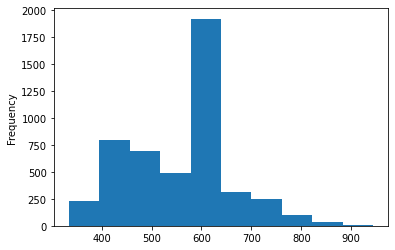

In [ ]:
# pegamos apenas os participantes cujo a situação é "já conclui o ensino médio"
concluiu_matematica_2021 = notas_hipotese[notas_hipotese['situacao_de_conclusao'] == 1.0]['matematica']
concluiu_matematica_2021.plot(kind='hist')

Através do histograma vemos que ele tende a se apróximar de uma distribuição normal.

Aqui fazemos o primeiro teste de hipótese. A **hipótese nula** é que o as notas de matemáticas de quem já concluiu o ensino médio se aproxima de uma distribuição normal, já a **hipótese alternativa** é que não se aproxima de uma distribuição normal.

Se o resultado é superior à 0.05 então podemos rejeitar a hipótese nula, nesse caso, se aproxima de uma distribuição normal.

In [ ]:
stats.shapiro(concluiu_matematica_2021)

ShapiroResult(statistic=0.9499668478965759, pvalue=8.187379989975866e-38)

Faremos a mesma coisa para os próximos tipos de situação

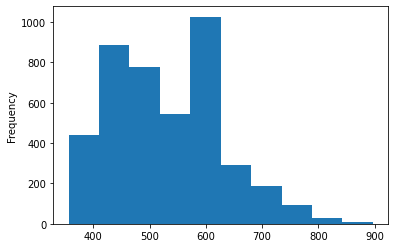

In [ ]:
# pegamos apenas os participantes cujo a situação é "estou cursando e concluirei em 2021"
ira_concluir_matematica_2021 = notas_hipotese[notas_hipotese['situacao_de_conclusao'] == 2.0]['matematica']
ira_concluir_matematica_2021.plot(kind='hist')

In [ ]:
stats.shapiro(ira_concluir_matematica_2021)

ShapiroResult(statistic=0.9636797904968262, pvalue=1.5845448733618235e-31)

Como pode ver, se aproxima de uma normal

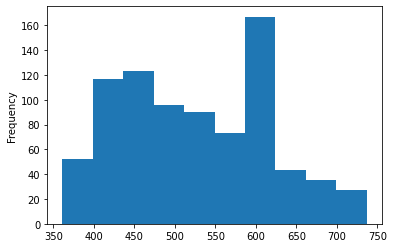

In [ ]:
# pegamos apenas os participantes cujo a situação é "estou cursando e concluirei após 2021"
ira_concluir_matematica_pos_2021 = notas_hipotese[notas_hipotese['situacao_de_conclusao'] == 3.0]['matematica']
ira_concluir_matematica_pos_2021.plot(kind='hist')

In [ ]:
stats.shapiro(ira_concluir_matematica_pos_2021)

ShapiroResult(statistic=0.9628955721855164, pvalue=1.3413600200191944e-13)

Como pode ver, novamente, se aproxima de uma normal

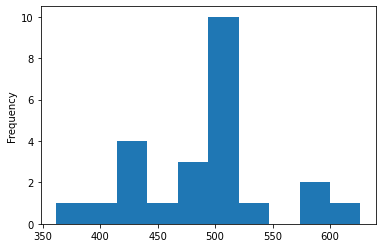

In [ ]:
# pegamos apenas os participantes cujo a situação é "não concluí e não estou cursando o ensino médio"
nao_cursa_em_matematica = notas_hipotese[notas_hipotese['situacao_de_conclusao'] == 4.0]['matematica']
nao_cursa_em_matematica.plot(kind='hist')

In [ ]:
stats.shapiro(nao_cursa_em_matematica)

ShapiroResult(statistic=0.9320076107978821, pvalue=0.10810405761003494)

Se aproxima também de uma normal

Sabemos que todos os testes de hipóteses anteriores mostraram que a distribuição segue a distribuição normal e por se tratarem de grupos diferentes poderemos utilizar agora o teste de hipótese ttest.

A hipótese nula é que nota de matemática de quem já concluiu o ensino médio é igual as notas de matemática de quem vai concluir em 2021 e a hipótese alternativa é que seja diferente.

In [ ]:
stats.ttest_ind(concluiu_matematica_2021, ira_concluir_matematica_2021)

Ttest_indResult(statistic=12.558131499185762, pvalue=7.090723088702822e-36)

Nessa amostra podemos concluir que a hipótese nula é verdadeira.

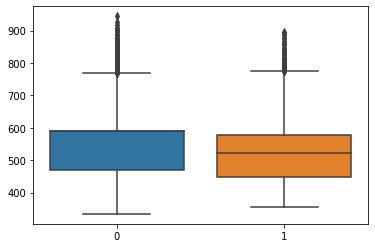

In [ ]:
sns.boxplot(data=[concluiu_matematica_2021, ira_concluir_matematica_2021])

A hipótese nula é que nota de matemática de quem já concluiu o ensino médio é igual as notas de matemática de quem vai concluir após 2021 e a hipótese alternativa é que seja diferente.

In [ ]:
stats.ttest_ind(concluiu_matematica_2021, ira_concluir_matematica_pos_2021)

Ttest_indResult(statistic=7.422865855535903, pvalue=1.3153290312613213e-13)

Nessa amostra podemos concluir que a hipótese nula é verdadeira.

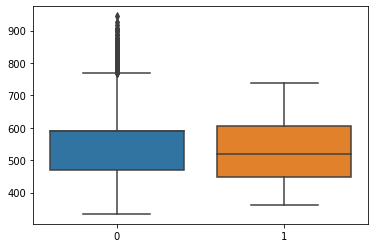

In [ ]:
sns.boxplot(data=[concluiu_matematica_2021, ira_concluir_matematica_pos_2021])

A hipótese nula é que nota de matemática de quem já concluiu o ensino médio é igual as notas de matemática de quem concluiu e não cursa o ensino médio 2021 e a hipótese alternativa é que seja diferente.

In [ ]:
stats.ttest_ind(concluiu_matematica_2021, nao_cursa_em_matematica)

Ttest_indResult(statistic=3.1405544652235946, pvalue=0.001696372677140016)

Nessa amostra podemos concluir que a hipótese nula é rejeitada.

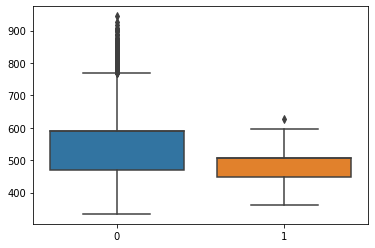

In [ ]:
sns.boxplot(data=[concluiu_matematica_2021, nao_cursa_em_matematica])